In [1]:
#!conda install -c conda-forge wordcloud

In [2]:
from sklearn import preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
# nltk.download('stopwords')
import pandas as pd, numpy as np
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

__В качестве заготовки для задания прогоним часть 2ого домашнего задания. Нам необходимо получить разреженные матрицы, используя CountVectorizer, TfidfVectorizer для 'tweet_stemmed' и 'tweet_lemmatized' столбцов (4 матрицы).__

In [3]:
combine_df = pd.read_pickle("data/processed_tweets.pkl")

In [4]:
combine_df.head(2)

,id,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[when, father, is, dysfunct, and, is, so, self...","[when, father, is, dysfunctional, and, is, so,..."
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...","[thank, for, lyft, credit, can, not, use, caus...","[thanks, for, lyft, credit, can, not, use, cau..."


In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [6]:
flat_tweet_stemmed = [item for sublist in combine_df['tweet_stemmed'] for item in sublist]
flat_tweet_lemmatized = [item for sublist in combine_df['tweet_lemmatized'] for item in sublist]

In [7]:
count_vectorizer_steammed = CountVectorizer(analyzer='word', 
                                            binary=False, 
                                            max_df=0.9, 
                                            max_features=1000, 
                                            stop_words='english')

count_vectorizer_lemmatized = CountVectorizer(analyzer='word', 
                                              binary=False, 
                                              max_df=0.9, 
                                              max_features=1000, 
                                              stop_words='english')


bag_of_words_steammed_cv = count_vectorizer_steammed.fit(flat_tweet_stemmed)
bag_of_words_lemmatized_cv = count_vectorizer_lemmatized.fit(flat_tweet_lemmatized)

In [8]:
tfidf_vectorizer_steammed = TfidfVectorizer(analyzer='word', 
                                            binary=False, 
                                            max_df=0.9, 
                                            max_features=1000, 
                                            stop_words='english')

tfidf_vectorizer_lemmatized = TfidfVectorizer(analyzer='word', 
                                              binary=False, 
                                              max_df=0.9, 
                                              max_features=1000, 
                                              stop_words='english')


bag_of_words_steammed_ti = tfidf_vectorizer_steammed.fit(flat_tweet_stemmed)
bag_of_words_lemmatized_ti = tfidf_vectorizer_lemmatized.fit(flat_tweet_lemmatized)

__Задание 1.__

__Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed'].__

_- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)_

_- Ответами является столбец train_df['label']_

_- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int_

_- Рассчитаем f1_score_

In [9]:
train_test_idx = 31962

print(f"Train:\n{combine_df['label'][:train_test_idx].value_counts(dropna=False)}\n")
print(f"Test:\n{combine_df['label'][train_test_idx:].value_counts(dropna=False)}")

Train:
0.0    29720
1.0     2242
Name: label, dtype: int64

Test:
NaN    17197
Name: label, dtype: int64


In [10]:
split_train_idx = int(train_test_idx*0.6)
split_train_idx

19177

In [11]:
train_x_st, valid_x_st, train_y, valid_y = \
    combine_df['tweet_stemmed'][:split_train_idx].apply(lambda x: " ".join(x)), \
    combine_df['tweet_stemmed'][split_train_idx:train_test_idx].apply(lambda x: " ".join(x)), \
    combine_df['label'][:split_train_idx], \
    combine_df['label'][split_train_idx:train_test_idx]

encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [12]:
xtrain_bow_steammed =  bag_of_words_steammed_cv.transform(train_x_st)
xvalid_bow_steammed =  bag_of_words_steammed_cv.transform(valid_x_st)

In [13]:
def train_model(classifier, feature_train, train_label, feature_valid, test_label, threshold=0.3):
    classifier.fit(feature_train, train_label)
    pred_proba = classifier.predict_proba(feature_valid)
    
    return metrics.f1_score([1 if prob[1]>=threshold else 0 for prob in pred_proba], test_label)

In [14]:
f1_st_bw = train_model(linear_model.LogisticRegression(random_state=27),
                       xtrain_bow_steammed,
                       train_y,
                       xvalid_bow_steammed,
                       valid_y)

__Повторим аналогично для столбца combine_df['tweet_lemmatized'].__

In [15]:
train_x_lm, valid_x_lm = combine_df['tweet_lemmatized'][:split_train_idx].apply(lambda x: " ".join(x)), \
                         combine_df['tweet_lemmatized'][split_train_idx:train_test_idx].apply(lambda x: " ".join(x))

In [16]:
xtrain_bow_lemmatized =  bag_of_words_lemmatized_cv.transform(train_x_lm)
xvalid_bow_lemmatized =  bag_of_words_lemmatized_cv.transform(valid_x_lm)

In [17]:
f1_lm_bw = train_model(linear_model.LogisticRegression(random_state=27),
                       xtrain_bow_lemmatized,
                       train_y,
                       xvalid_bow_lemmatized,
                       valid_y)

__Задание 2.__

__Построим модель LogisticRegression, используя TF-IDF признаки для столбца combine_df['tweet_stemmed'].__

_- Поделим TF-IDF признаки на train, test (train заканчивается на 31962 строке combine_df)_

_- Ответами является столбец train_df['label']_

_- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int_

_- Рассчитаем f1_score_

In [18]:
xtrain_ti_steammed =  bag_of_words_steammed_ti.transform(train_x_st)
xvalid_ti_steammed =  bag_of_words_steammed_ti.transform(valid_x_st)

In [19]:
f1_st_ti = train_model(linear_model.LogisticRegression(random_state=27),
                       xtrain_ti_steammed,
                       train_y,
                       xvalid_ti_steammed,
                       valid_y)

__Повторим аналогично для столбца combine_df['tweet_lemmatized'].__

In [20]:
xtrain_ti_lemmatized =  bag_of_words_lemmatized_ti.transform(train_x_lm)
xvalid_ti_lemmatized =  bag_of_words_lemmatized_ti.transform(valid_x_lm)

In [21]:
f1_lm_ti = train_model(linear_model.LogisticRegression(random_state=27),
                       xtrain_ti_lemmatized,
                       train_y,
                       xvalid_ti_lemmatized,
                       valid_y)

__Задание 3.__

__Выведите результаты f1-score всех моделей, сделайте вывод.__

In [22]:
print(f"Bag-of-Words - tweet_stemmed: \n{f1_st_bw}\n")
print(f"Bag-of-Words - tweet_lemmatized: \n{f1_lm_bw}\n")
print(f"TF-IDF - tweet_stemmed: \n{f1_st_ti}\n")
print(f"TF-IDF - tweet_lemmatized: \n{f1_lm_ti}\n")

Bag-of-Words - tweet_stemmed: 
0.5332472562943834

Bag-of-Words - tweet_lemmatized: 
0.5348837209302326

TF-IDF - tweet_stemmed: 
0.5410821643286573

TF-IDF - tweet_lemmatized: 
0.5321831453218315



F1-score на всех моделях близки, из-за похожести признаков и большого их количества, другие гиперпараметры этих моделей и другие типы моделей могут увеличить качество. Признаки Bag-of-Words для tweet_lemmatized показали себя лучше, чем для tweet_stemmed. Признаки TF-IDF наоборот показали себя лучше для для tweet_stemmed.

__Задание 4.__

__Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).__

__Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.__

_- объединим слова в одну строку_

_- создадим словарь частот слов с помощью collections.Counter_

_- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()_

_- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова_

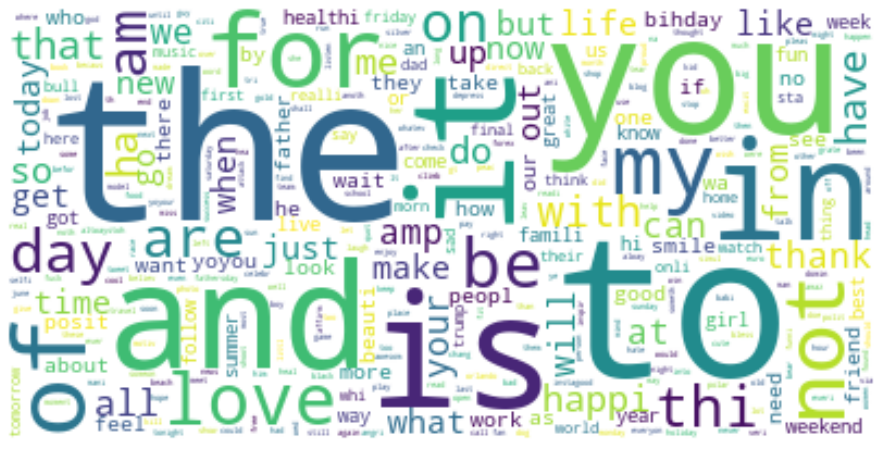

In [23]:
wordfreq = Counter(flat_tweet_stemmed)
wordcloud = WordCloud(background_color='white',
                      max_words=2000,
                      stopwords=stopwords).generate_from_frequencies(wordfreq)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

__Задание 5.__

__Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0).__

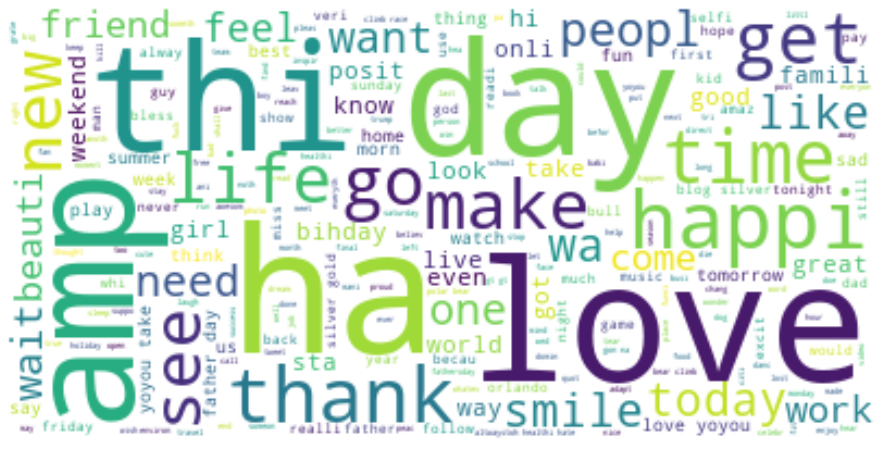

In [24]:
pos_words = ''
for line in combine_df[combine_df['label']==0]['tweet_stemmed']:
    pos_words += ' '.join(line)

wordcloud = WordCloud(background_color='white',
                      max_words=50000,
                      stopwords=set(stopwords.words('english'))).generate(pos_words)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

__Задание 6.__

__Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1).__

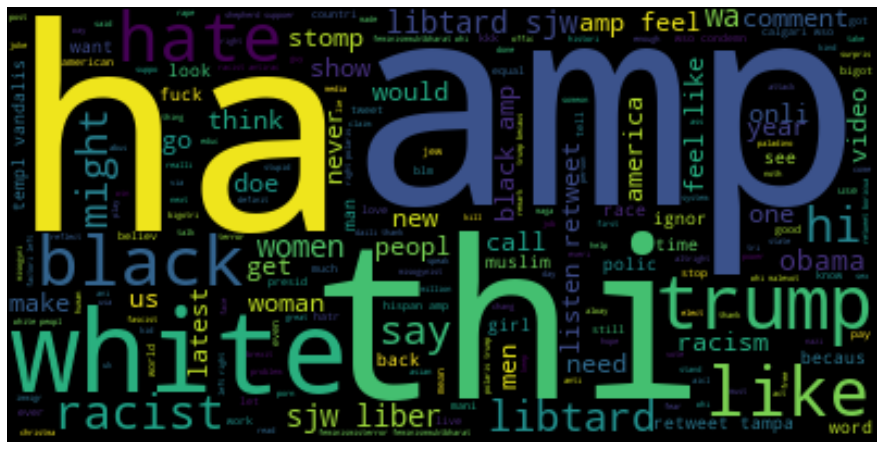

In [25]:
neg_words = ''
for line in combine_df[combine_df['label']==1]['tweet_stemmed']:
    neg_words += ' '.join(line)

wordcloud = WordCloud(background_color='black',
                      max_words=50000,
                      stopwords=set(stopwords.words('english'))).generate(neg_words)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()